In [145]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#the main lib here is the statmodel
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA

## Stock Prices Forecasting
For our practical class we will be forecasting the stock prices of some of the biggest stock markets in the world. This will be a guide on how to structure your Time Series Forecasting Project.

## 1. Problem Statement

S&P 500 is a stock market index tracking the stock performance of 500 leading companies listed on stock exchanges in the United States. The index represents the financial health and performance of the US economy. Forecasting the future prices of the index is important for fund managers, banks and investors to measure and prepare for how risky the market might be as well as guide them on when to invest more money and when to pull back.

In this project, we are going to use the historical stock prices of the S&P 500, from 1994-2018 to forecast future prices, we will test out and compare the performance of different time series models.



## 2. Loading and Exploring your data (EDA)

In [146]:
# read the data
df=pd.read_csv(r'D:\Advanced_Machine_Learning\datasets\Stock_prices.csv.csv')

In [147]:
df.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


Just like in any ML workflow, the first place to begin is checking for missingness.

In [148]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6269 entries, 0 to 6268
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6269 non-null   object 
 1   spx     6269 non-null   float64
 2   dax     6269 non-null   float64
 3   ftse    6269 non-null   float64
 4   nikkei  6269 non-null   float64
dtypes: float64(4), object(1)
memory usage: 245.0+ KB


The first thing I notice is that, our date column is not the correct data type. All time-series should be a date-time object. Second, the date column should be the index of the dataframe

In [149]:
#convert date column to datetime object
df['date']=pd.to_datetime(df['date'],errors='coerce',dayfirst=True)

In [150]:
df.set_index('date',inplace=True)

Also, the stock markets usually run during the week and close over the weekend, meaning our stock prices change from Monday to Friday, and there are no changes on Saturday and Sunday.So let's confirm that our data is accurate and reflect the stock prices during the active market days.

In [151]:
df_trading = df[df.index.dayofweek < 5]

In [152]:
df_trading.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6269 entries, 1994-01-07 to 2018-01-29
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spx     6269 non-null   float64
 1   dax     6269 non-null   float64
 2   ftse    6269 non-null   float64
 3   nikkei  6269 non-null   float64
dtypes: float64(4)
memory usage: 244.9 KB


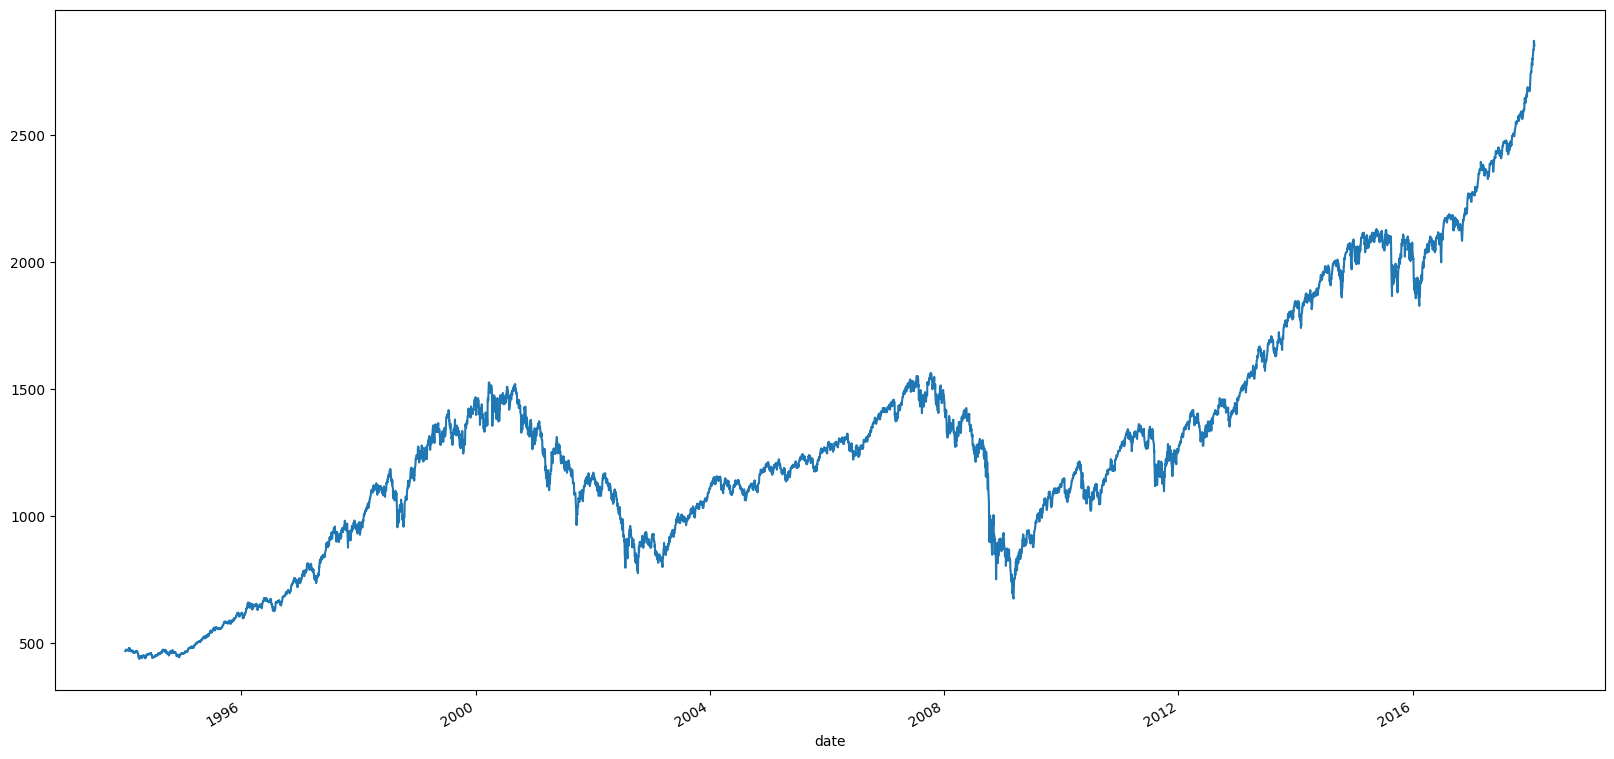

In [153]:
plt.figure(figsize=(20,10))
df_trading['spx'].plot()
plt.show()

So from the plot above, I can see some slight trend- the time series is increasing in trend. I also suspect a seasonal component. I know, it can be confusing, a great way to confirm if your data has seasonality and/or trend is to perform a time-series decomposition. This just means breaking down the time-series into its trend, seasonal and residual (noise) component. We use the statsmodels library for this

Now, for time-series decomposition you have 2 options, you can perform naive decomposition or a more advanced technique. We have 2 approaches under naive, additive or multiplicative. In additive, we assume that the timeseries is a sum of the time components and multiplicative we assume its a product.

**When to choose between additive and multiplicative**
Generally, use an additive decomposition when seasonal variation is constant over time and then use multiplicative when you notice your seasonal effects become bigger with the trend. For me, I used multiplicative, because the seasonal variance is not constant.

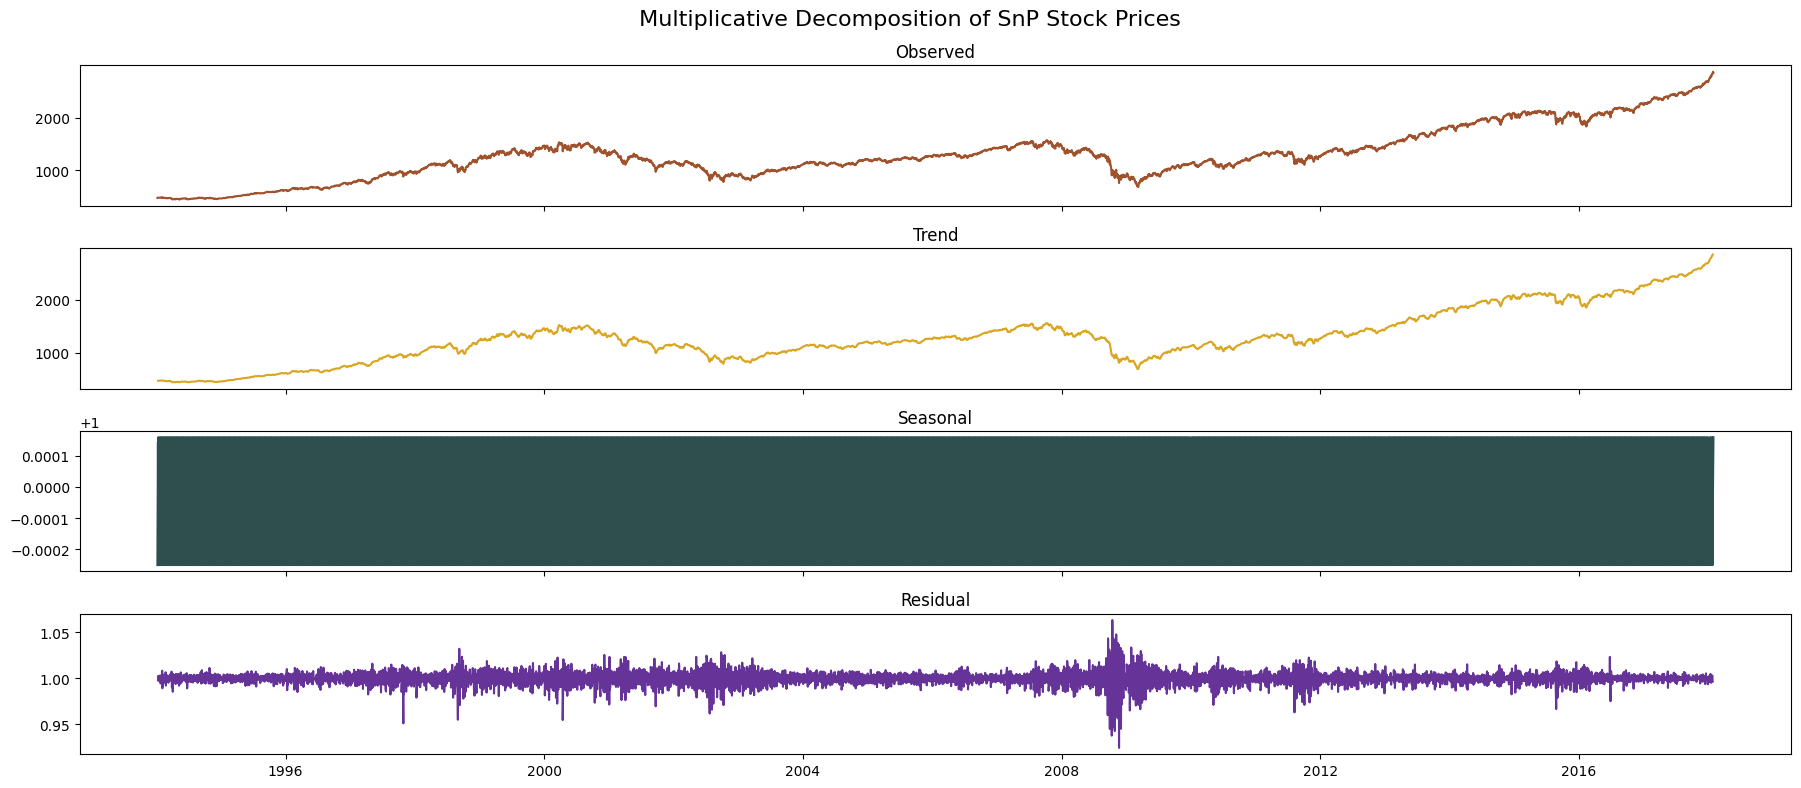

In [154]:
result = seasonal_decompose(df['spx'], model='multiplicative', period=5)


# Plot and save classical decomp components
fig, axs = plt.subplots(4, 1, figsize=(18, 8), sharex=True)

axs[0].plot(result.observed, color='sienna')
axs[0].set_title('Observed')

axs[1].plot(result.trend, color='goldenrod')
axs[1].set_title('Trend')

axs[2].plot(result.seasonal, color='darkslategrey')
axs[2].set_title('Seasonal')

axs[3].plot(result.resid, color='rebeccapurple')
axs[3].set_title('Residual')

plt.suptitle(' Multiplicative Decomposition of SnP Stock Prices', fontsize=16)
plt.tight_layout()

What the above decomposition plot tells us is, there is no seasonality in our time series data. Which checks out for stock price data-stock prices are highly volatile, so it makes sense that the decomposition did not find any repeating pattern every 5 days.
I used a more advanced decomposition technique called STL- Seasonal and Trend decomposition using Loess, just to be sure (and to give you another reference in case you need it), and it confirmed that indeed my time series data has no seasonality.

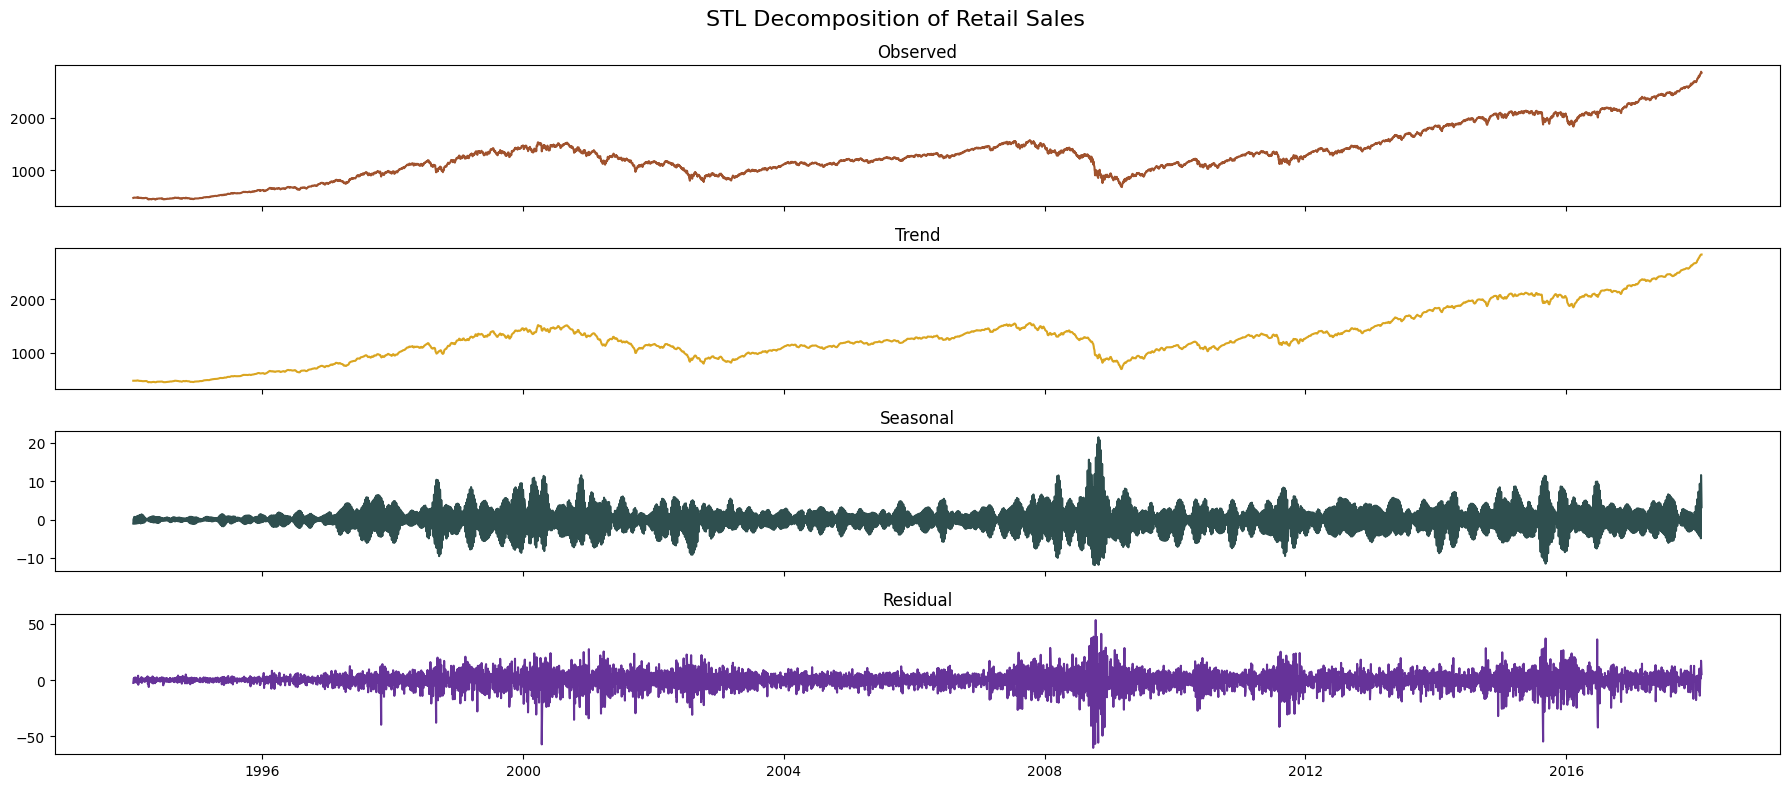

In [155]:
# Apply STL decomposition
stl = STL(df_trading['spx'], seasonal=13,period=5)
result = stl.fit()

# Plot and save STL components
fig, axs = plt.subplots(4, 1, figsize=(18, 8), sharex=True)

axs[0].plot(result.observed, color='sienna')
axs[0].set_title('Observed')

axs[1].plot(result.trend, color='goldenrod')
axs[1].set_title('Trend')

axs[2].plot(result.seasonal, color='darkslategrey')
axs[2].set_title('Seasonal')

axs[3].plot(result.resid, color='rebeccapurple')
axs[3].set_title('Residual')

plt.suptitle('STL Decomposition of Retail Sales', fontsize=16)
plt.tight_layout()
plt.show()

#### Insights from Time-Series Decomposition
- The time series has no seasonality and therefore, I do not need any models like SARIMA that has a seasonal component.
- The trend component explains most of the variability in our time-series data
- The time series is non-stationary as it has trend

#### Checking for Stationarity

In [156]:
result = adfuller(df_trading['spx'])

In [157]:
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

# Decision based on p-value
if result[1] <= 0.05:
    print("Reject the null hypothesis (H0). The time series is stationary.")
else:
    print("The p values is more than 0.05,Fail to reject the null hypothesis (H0). The time series is non-stationary.")

ADF Statistic: 1.0724042027036529
p-value: 0.9949740839827675
Critical Values:
	1%: -3.4313967180469573
	5%: -2.862002556554404
	10%: -2.5670162159104
The p values is more than 0.05,Fail to reject the null hypothesis (H0). The time series is non-stationary.


## 3. Data Pre-Processing

We have learned from our EDA that our data is non-stationary, and that the non-stationarity is likely because of the trend. Our first pre-processing step therefore is to make our data stationary by addressing the trend component. For trend, which means it is the mean that is non-stationary, simple trend differencing would suffice. In case we had seasonanily, which is variance non-stationary- seasonal differencing or log/box-cox transformations would be the best.

Let's proceed with our trend differencing

In [158]:
#difference the stock prices, first order differencing

diff_spx = df_trading['spx'].diff(periods=1).dropna()
print(diff_spx)

date
1994-01-10     5.370000
1994-01-11    -1.140000
1994-01-12     0.040000
1994-01-13    -1.700000
1994-01-14     2.440000
                ...    
2018-01-23     6.156262
2018-01-24    -1.586354
2018-01-25     1.709023
2018-01-26    33.614808
2018-01-29   -19.339428
Name: spx, Length: 6268, dtype: float64


Now let's plot the differenced time series and confirm that it is now stationary. Is it stationary? Why do you think so?

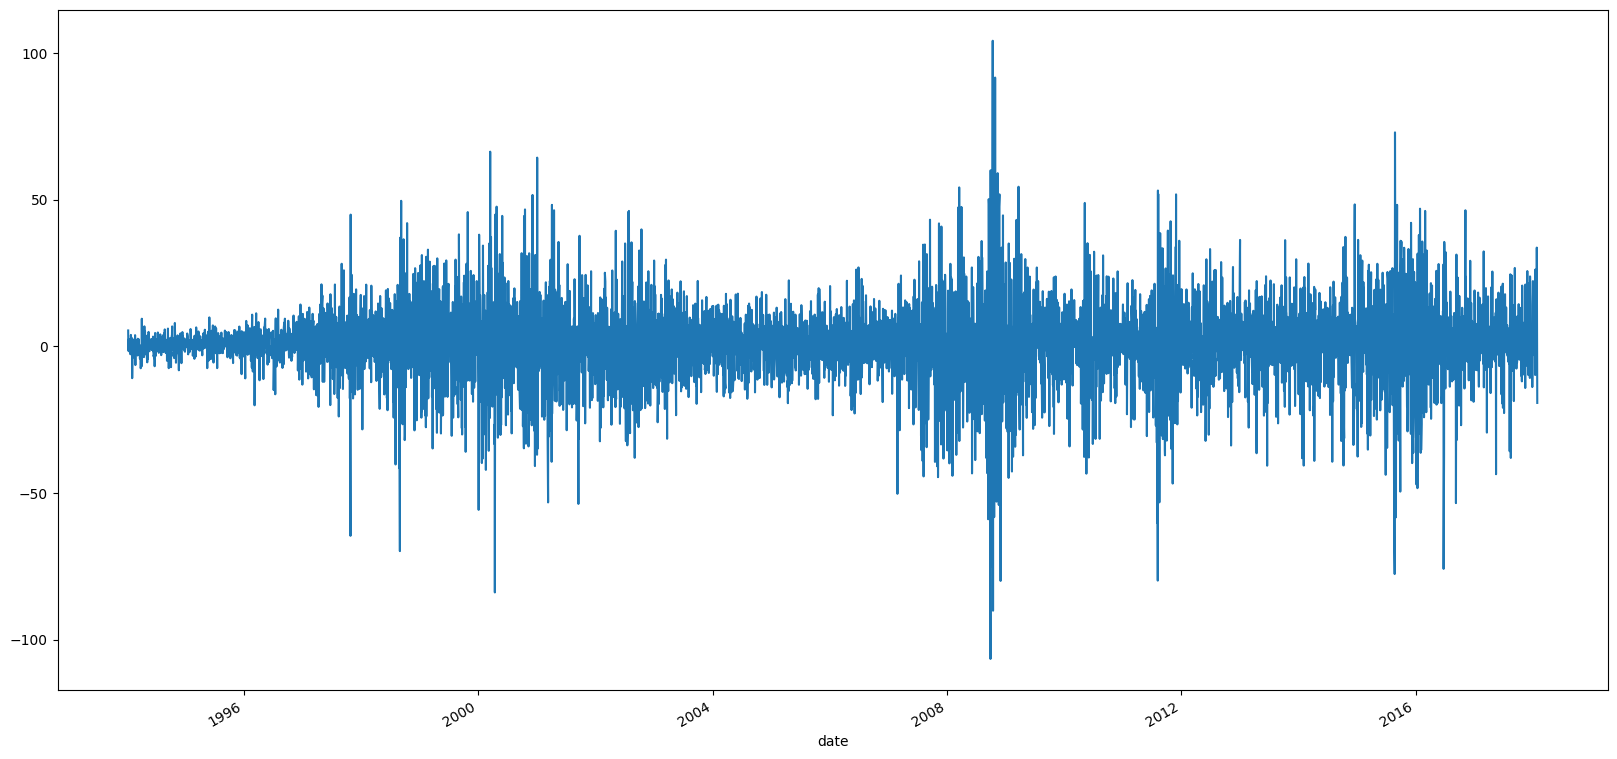

In [159]:
plt.figure(figsize=(20,10))
diff_spx.plot()
plt.show()

### Autocorrelation

<Figure size 1000x300 with 0 Axes>

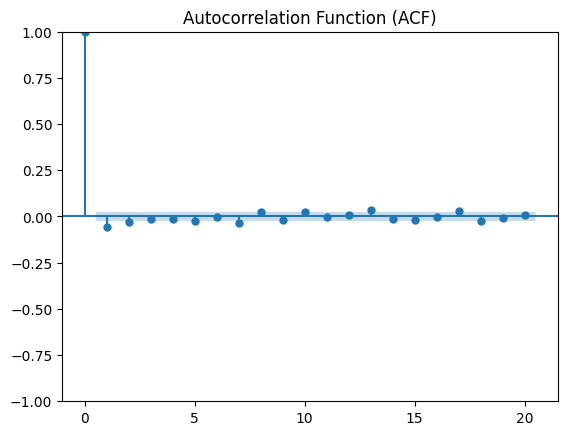

In [160]:
plt.figure(figsize=(10, 3))

# Plot ACF
plot_acf(diff_spx,lags=20, title='Autocorrelation Function (ACF)')
plt.show()


<Figure size 1000x100 with 0 Axes>

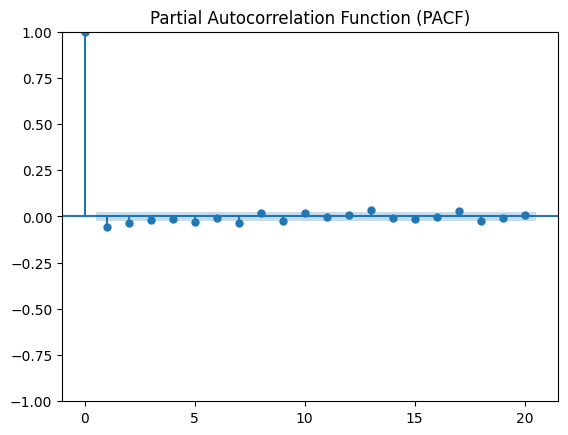

In [161]:
plt.figure(figsize=(10, 1))

# Plot PACF
plot_pacf(diff_spx,method='ols',lags=20,title='Partial Autocorrelation Function (PACF)')
plt.show()


#### Insights from ACF/PACF plots
From the ACF plot, the autocorrelation coefficient cuts off after lag 1( though we can also test for 2), so our parameter q for the MA model is 1. From the PACF plot, the coefficient also cuts off after lag one, so our value for p for the AR model is 1(though we can test our 2).

So we are going to try to fit an ARMA model of ARMA(1,1) and try ARMA(2,2)

### 4. Modelling

Alright, remember in the last class we learned about ARMA and ARIMA, the only difference between these two time series models is that ARIMA handles the differencing internally, which means you feed it non-stationary data. For ARMA, it expects stationary (differenced time series) data. Since we have already differenced our data, I will only be testing ARMA models with different parameters and compare their performances.

##### Train-Test Split

In [162]:
df_trading.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [163]:
df_trading = df_trading[['spx']]
df_trading.head()

,spx
date,
1994-01-07,469.90
1994-01-10,475.27
1994-01-11,474.13
1994-01-12,474.17
1994-01-13,472.47


In [164]:
split_point = int(len(diff_spx) * 0.8)  

train= df_trading['spx'].iloc[:split_point] # Data used for fitting
test= df_trading['spx'].iloc[split_point:]   # Data used for evaluating forecasts

print(f"Total data points: {len(diff_spx)}")
print(f"Training data points: {len(train_diff)}")
print(f"Testing data points: {len(test_diff)}")

Total data points: 6268
Training data points: 5014
Testing data points: 1255


In [165]:
test.head()

date
2013-04-03    1553.686978
2013-04-04    1559.979316
2013-04-05    1553.278930
2013-04-08    1563.071269
2013-04-09    1568.607909
Name: spx, dtype: float64

In [166]:
#Now fit the models
arma11_model = ARIMA(train.values, order=(1, 1, 1))
arma11_fit = arma11_model.fit()
print(arma11_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5014
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -20047.024
Date:                Thu, 04 Dec 2025   AIC                          40100.047
Time:                        16:22:21   BIC                          40119.607
Sample:                             0   HQIC                         40106.902
                               - 5014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6091      0.062      9.751      0.000       0.487       0.732
ma.L1         -0.6765      0.057    -11.969      0.000      -0.787      -0.566
sigma2       174.1877      1.768     98.521      0.0

In [172]:
# Lets try another model
arma22_model = ARIMA(train.values, order=(2, 1, 2))
arma22_fit = arma22_model.fit()
arma22_fit.summary()


d:\Advanced_Machine_Learning\adml-env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Advanced_Machine_Learning\adml-env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5014
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -20046.000
Date:                Thu, 04 Dec 2025   AIC                          40102.000
Time:                        16:22:34   BIC                          40134.599
Sample:                             0   HQIC                         40113.424
                               - 5014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2201      0.128     -1.713      0.087      -0.472       0.032
ar.L2          0.5556      0.086      6.471      0.000       0.387       0.724
ma.L1          0.1483      0.128      1.159      0.247      -0.103       0.399
ma.L2         -0.6006      0.091     -6.635      0.000      -0.778      -0.423
sigma2       174.1164      1.776     98.026      0.000     170.635     177.598
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7326.34
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.27   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Looks like the ARMA(1,1) model performs better, the next step is to check the residuals to confirm that the model has adequately captured the autocorrelation and systematic patterns in the time series. If it has done so, we expect that the residuals will look like white noise.

Think about it this way, if the residuals- simply the difference between the predicted and observed stock prices at time t are not random, if they exhibit some kind of pattern it means our model did not fit our data very well. It did not learn well.

If the residuals are not White Noise, it means:You have not chosen the correct model orders ($p$ and $q$).The model is misspecified (e.g., you need to add seasonality, handle non-constant variance, or include external variables).

#### 4.1 Residual Diagnosis

In [173]:
#get the residuals
residuals = arma11_fit.resid


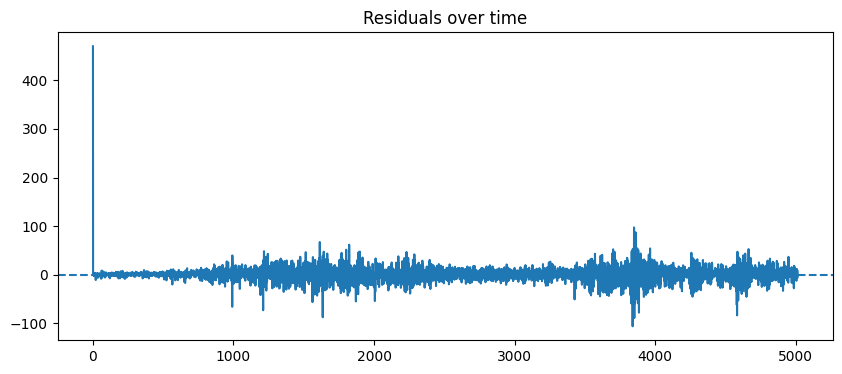

In [174]:
#plot the residuals over time
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.axhline(0, linestyle='--')
plt.title("Residuals over time")
plt.show()


You want to see:

- Fluctuations around 0
- No clear trend
- No obvious seasonality
- No big “blocks” of high or low variance

Clearly, this confirms that our residuals are indeed random and that our model has learned the autocorrelated component well.

### 5. Forecasting & Model Evaluation

In [ ]:
# Forecast the same number of steps as the test set
n_steps = len(test)
forecast_obj = arma11_fit.get_forecast(steps=n_steps)

# Extract predicted mean and confidence intervals
y_pred = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

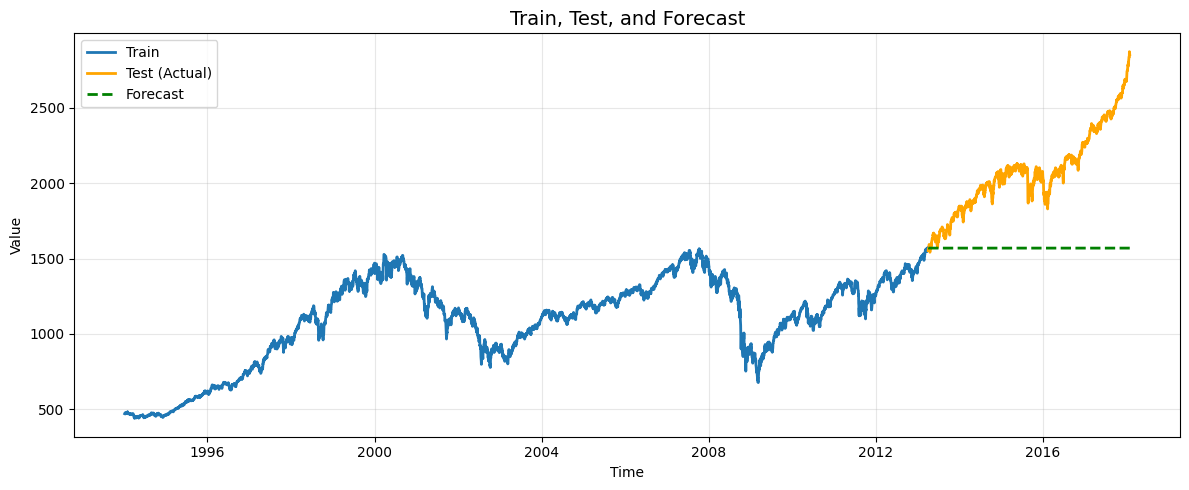

In [182]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 1. Train data
plt.plot(train.index,train.values,label='Train',linewidth=2)

# 2. Test data (actual values)
plt.plot(test.index,test.values,label='Test (Actual)',color='orange',linewidth=2)

# 3. Forecast for test period
plt.plot(test.index,y_pred,label='Forecast',color='green',linestyle='--',linewidth=2)

plt.title('Train, Test, and Forecast', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


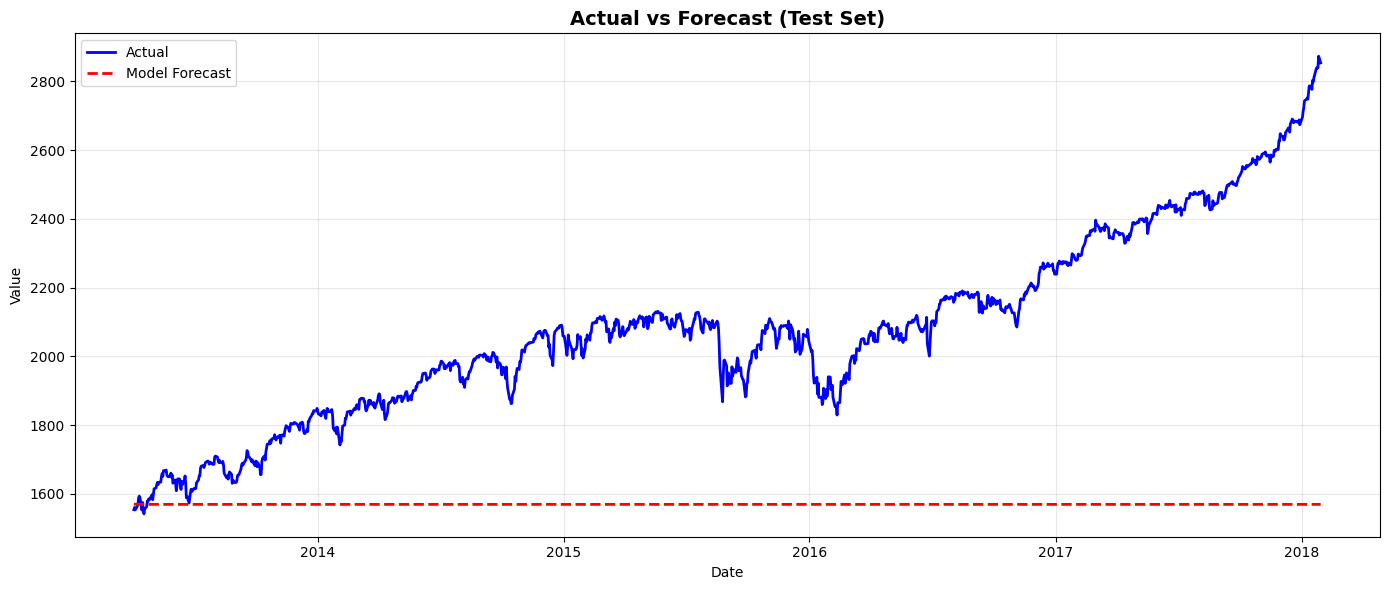

In [184]:
plt.figure(figsize=(14, 6))

# Actual values (test set)
plt.plot(test.index,
         test.values,
         label='Actual',
         color='blue',
         linewidth=2)

# Forecast from your model
plt.plot(test.index,
         y_pred,
         label='Model Forecast',
         color='red',
         linewidth=2,
         linestyle='--')

plt.title('Actual vs Forecast (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
